In [1]:
!nvidia-smi

Wed Nov 27 14:47:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:B5:00.0 Off |                    0 |
| N/A   43C    P0              87W / 350W |  22040MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import os 
import torch
import evaluate
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
from copy import deepcopy
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchvision import transforms
from transformers import get_scheduler
from transformers import TrainingArguments
from torch.utils.data import Dataset, DataLoader, Subset
from peft import (
    PeftModel, 
    LoraConfig, 
    get_peft_model, 
    AdaLoraConfig,
    IA3Config,
    LoHaConfig,
    LoKrConfig,
)
from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torchvision.transforms import (
    Compose, 
    Normalize, 
    Resize, 
    ToTensor
)

2024-11-27 14:47:09.714568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 14:47:15.976093: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
def print_model_size(path):
    '''Calculates and prints the combined size of all files in the specified directory in megabytes.'''
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)
    print(f"Model size: {(size / 1e6):.2} MB")

def print_trainable_parameters(model, label):
    '''Prints how many parameters in the model are trainable versus the total, along with the percentage.'''
    parameters, trainable = 0, 0
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0
    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")

def create_label_mappings(dataset):
    '''Creates dictionaries mapping labels to numeric IDs and vice versa.'''
    label2id, id2label = dict(), dict()
    unique_labels = set([label for _, label in dataset.samples]) 
    for i, label in enumerate(unique_labels):
        label2id[label] = i
        id2label[i] = label
    return label2id, id2label


In [6]:
class CustomDataset(Dataset):
    '''A custom dataset that loads a fraction of images from subdirectories, applies transformations, and returns images with label IDs.'''
    def __init__(self, root_dir, transform=None, load_fraction=0.1):
        self.transform = transform
        self.samples = []
        self.label2id = {}
        class_id = 0
        for class_dir in os.listdir(root_dir):
            self.label2id[class_dir] = class_id
            class_id += 1
            class_path = os.path.join(root_dir, class_dir)
            all_files = os.listdir(class_path)
            sample_count = int(len(all_files) * load_fraction)
            chosen_files = np.random.choice(all_files, sample_count, replace=False)
            for filename in chosen_files:
                self.samples.append((os.path.join(class_path, filename), class_dir))

    def __len__(self):
        '''Returns the total number of samples.'''
        return len(self.samples)

    def __getitem__(self, idx):
        '''Loads an image by index, applies transforms if any, and returns the image with its label ID.'''        
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            processed = self.transform(image)
            image = processed['pixel_values'][0]  
        return image, self.label2id[label]

    def set_transform(self, transform):
        '''Sets a new transform function.'''
        self.transform = transform

    def get_image_path(self, idx):
        '''Returns the original image file path for a given index.'''
        img_path, _ = self.samples[idx] 
        return img_path

def split_dataset(dataset, test_size=0.1, shuffle=True):
    '''Splits the dataset into train and test subsets.'''
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, shuffle=shuffle)
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    return train_dataset, test_dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])


In [7]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocess_pipeline = Compose([
    lambda image: {
        'pixel_values': torch.tensor(image_processor(image.convert("RGB")).pixel_values)
    }
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
base_dir = '/projects/academic/shamsadp/medxformer'
disease_dirs = {
    "brain": os.path.join(base_dir, "brain"),
    "diabetic": os.path.join(base_dir, "diabetic"),
    "skin": os.path.join(base_dir, "skin"),
    "retina": os.path.join(base_dir, "retina"),
    "kidney": os.path.join(base_dir, "kidney")
}

allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def count_images_in_classes(disease_dir):
    '''Prints the number of images in each class subdirectory within a given disease directory.'''
    for class_name in os.listdir(disease_dir):
        class_path = os.path.join(disease_dir, class_name)
        if os.path.isdir(class_path):
            image_count = sum(
                1 for file in os.listdir(class_path) if file.lower().endswith(allowed_extensions)
            )
            print(f"Class '{class_name}' has {image_count} images.")

for disease, disease_path in disease_dirs.items():
    if os.path.exists(disease_path):
        print(f"\nCounting images in {disease} dataset...")
        count_images_in_classes(disease_path)
    else:
        print(f"[ERROR] Disease directory '{disease}' does not exist at path '{disease_path}'.")


Counting images in brain dataset...
Class 'brain_glioma' has 1621 images.
Class 'brain_meningioma' has 1645 images.
Class 'brain_no_tumor' has 2000 images.
Class 'brain_pituitary' has 1757 images.

Counting images in diabetic dataset...
Class 'diabetic_mild_retinopathy' has 2000 images.
Class 'diabetic_moderate_retinopathy' has 2000 images.
Class 'diabetic_no_retinopathy' has 2000 images.
Class 'diabetic_proliferative_retinopathy' has 2000 images.
Class 'diabetic_severe_retinopathy' has 2000 images.

Counting images in skin dataset...
Class 'skin_actinic_keratosis' has 2000 images.
Class 'skin_basal_cell_carcinoma' has 2000 images.
Class 'skin_dermatofibroma' has 2000 images.
Class 'skin_melanoma' has 2000 images.
Class 'skin_nevus' has 2000 images.
Class 'skin_pigmented_benign_keratosis' has 2000 images.
Class 'skin_seborrheic_keratosis' has 2000 images.
Class 'skin_squamous_cell_carcinoma' has 2000 images.
Class 'skin_vascular_lesion' has 2000 images.

Counting images in retina data

In [9]:
base_dir = '/projects/academic/shamsadp/medxformer/'

brain_dataset = CustomDataset(f'{base_dir}brain', transform=preprocess_pipeline, load_fraction=1)
diabetic_dataset = CustomDataset(f'{base_dir}diabetic', transform=preprocess_pipeline, load_fraction=1)
skin_cancer_dataset = CustomDataset(f'{base_dir}skin', transform=preprocess_pipeline, load_fraction=1)
retina_dataset = CustomDataset(f'{base_dir}retina', transform=preprocess_pipeline, load_fraction=1)
kidney_dataset = CustomDataset(f'{base_dir}kidney', transform=preprocess_pipeline, load_fraction=1)

brain_train_dataset, brain_test_dataset = split_dataset(brain_dataset, test_size=0.2)
diabetic_train_dataset, diabetic_test_dataset = split_dataset(diabetic_dataset, test_size=0.2)
skin_train_dataset, skin_test_dataset = split_dataset(skin_cancer_dataset, test_size=0.2)
retina_train_dataset, retina_test_dataset = split_dataset(retina_dataset, test_size=0.2)
kidney_train_dataset, kidney_test_dataset = split_dataset(kidney_dataset, test_size=0.2)

print("Datasets are successfully loaded and split into training and testing sets.")

Datasets are successfully loaded and split into training and testing sets.


In [10]:
def print_batch_shapes(dataset):
    '''Prints the shape of the first image and its label, along with the total size of the dataset.'''
    image, label = dataset[0]  
    print("Image shape: ", image.shape) 
    print("Label: ", label) 
    print("Dataset size: ", len(dataset))  

print("Shapes for Brain Dataset Train Loader:")
print_batch_shapes(brain_train_dataset)
print("\nShapes for Brain Dataset Test Loader:")
print_batch_shapes(brain_test_dataset)

print("\nShapes for Diabetic Dataset Train Loader:")
print_batch_shapes(diabetic_train_dataset)
print("\nShapes for Diabetic Dataset Test Loader:")
print_batch_shapes(diabetic_test_dataset)

print("\nShapes for Skin Cancer Dataset Train Loader:")
print_batch_shapes(skin_train_dataset)
print("\nShapes for Skin Cancer Dataset Test Loader:")
print_batch_shapes(skin_test_dataset)

print("\nShapes for Retina Dataset Train Loader:")
print_batch_shapes(retina_train_dataset)
print("\nShapes for Retina Dataset Test Loader:")
print_batch_shapes(retina_test_dataset)

print("\nShapes for Kidney Dataset Train Loader:")
print_batch_shapes(kidney_train_dataset)
print("\nShapes for Kidney Dataset Test Loader:")
print_batch_shapes(kidney_test_dataset)


Shapes for Brain Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  5618

Shapes for Brain Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  3
Dataset size:  1405

Shapes for Diabetic Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  8000

Shapes for Diabetic Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  2000

Shapes for Skin Cancer Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  6
Dataset size:  14400

Shapes for Skin Cancer Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  3
Dataset size:  3600

Shapes for Retina Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  3
Dataset size:  16000

Shapes for Retina Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  3
Dataset size:  4000

Shapes for Kidney Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  3
Dataset size

In [11]:
brain_dataset_id2label = {v: k for k, v in brain_dataset.label2id.items()}
brain_dataset_label2id = brain_dataset.label2id

diabetic_dataset_id2label = {v: k for k, v in diabetic_dataset.label2id.items()}
diabetic_dataset_label2id = diabetic_dataset.label2id

skin_cancer_dataset_id2label = {v: k for k, v in skin_cancer_dataset.label2id.items()}
skin_cancer_dataset_label2id = skin_cancer_dataset.label2id

retina_dataset_id2label = {v: k for k, v in retina_dataset.label2id.items()}
retina_dataset_label2id = retina_dataset.label2id

kidney_dataset_id2label = {v: k for k, v in kidney_dataset.label2id.items()}
kidney_dataset_label2id = kidney_dataset.label2id

print("Brain Tumor Dataset Label to ID Mapping:", brain_dataset_id2label)
print("\nDiabetic Dataset Label to ID Mapping:", diabetic_dataset_id2label)
print("\nSkin Cancer Dataset Label to ID Mapping:", skin_cancer_dataset_id2label)
print("\nRetina Dataset Label to ID Mapping:", retina_dataset_id2label)
print("\nKidney Dataset Label to ID Mapping:", kidney_dataset_id2label)

Brain Tumor Dataset Label to ID Mapping: {0: 'brain_glioma', 1: 'brain_meningioma', 2: 'brain_no_tumor', 3: 'brain_pituitary'}

Diabetic Dataset Label to ID Mapping: {0: 'diabetic_mild_retinopathy', 1: 'diabetic_moderate_retinopathy', 2: 'diabetic_no_retinopathy', 3: 'diabetic_proliferative_retinopathy', 4: 'diabetic_severe_retinopathy'}

Skin Cancer Dataset Label to ID Mapping: {0: 'skin_actinic_keratosis', 1: 'skin_basal_cell_carcinoma', 2: 'skin_dermatofibroma', 3: 'skin_melanoma', 4: 'skin_nevus', 5: 'skin_pigmented_benign_keratosis', 6: 'skin_seborrheic_keratosis', 7: 'skin_squamous_cell_carcinoma', 8: 'skin_vascular_lesion'}

Retina Dataset Label to ID Mapping: {0: 'retina_choroidal_neovascularization', 1: 'retina_diabetic_macular_edema', 2: 'retina_drusen', 3: 'retina_normal'}

Kidney Dataset Label to ID Mapping: {0: 'kidney_cyst', 1: 'kidney_normal', 2: 'kidney_stone', 3: 'kidney_tumor'}


In [12]:
def check_unique_labels(dataset, id2label, batch_size=64):
    '''Prints all unique labels found in the dataset and their corresponding names.'''
    unique_labels = set()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch in dataloader:
        _, labels = batch
        unique_labels.update(labels.tolist())

        if len(unique_labels) == len(id2label):
            break
    print("Unique labels in the dataset:")
    for label in unique_labels:
        print(f"Label {label}: {id2label.get(label, 'Unknown label')}")

print("Unique labels in brain_train_dataset:")
check_unique_labels(brain_train_dataset, brain_dataset_id2label)

print("\nUnique labels in brain_test_dataset:")
check_unique_labels(brain_test_dataset, brain_dataset_id2label)

print("\nUnique labels in diabetic_train_dataset:")
check_unique_labels(diabetic_train_dataset, diabetic_dataset_id2label)

print("\nUnique labels in diabetic_test_dataset:")
check_unique_labels(diabetic_test_dataset, diabetic_dataset_id2label)

print("\nUnique labels in skin_cancer_train_dataset:")
check_unique_labels(skin_train_dataset, skin_cancer_dataset_id2label)

print("\nUnique labels in skin_cancer_test_dataset:")
check_unique_labels(skin_test_dataset, skin_cancer_dataset_id2label)

print("\nUnique labels in retina_train_dataset:")
check_unique_labels(retina_train_dataset, retina_dataset_id2label)

print("\nUnique labels in retina_test_dataset:")
check_unique_labels(retina_test_dataset, retina_dataset_id2label)

print("\nUnique labels in kidney_train_dataset:")
check_unique_labels(kidney_train_dataset, kidney_dataset_id2label)

print("\nUnique labels in kidney_test_dataset:")
check_unique_labels(kidney_test_dataset, kidney_dataset_id2label)


Unique labels in brain_train_dataset:
Unique labels in the dataset:
Label 0: brain_glioma
Label 1: brain_meningioma
Label 2: brain_no_tumor
Label 3: brain_pituitary

Unique labels in brain_test_dataset:
Unique labels in the dataset:
Label 0: brain_glioma
Label 1: brain_meningioma
Label 2: brain_no_tumor
Label 3: brain_pituitary

Unique labels in diabetic_train_dataset:
Unique labels in the dataset:
Label 0: diabetic_mild_retinopathy
Label 1: diabetic_moderate_retinopathy
Label 2: diabetic_no_retinopathy
Label 3: diabetic_proliferative_retinopathy
Label 4: diabetic_severe_retinopathy

Unique labels in diabetic_test_dataset:
Unique labels in the dataset:
Label 0: diabetic_mild_retinopathy
Label 1: diabetic_moderate_retinopathy
Label 2: diabetic_no_retinopathy
Label 3: diabetic_proliferative_retinopathy
Label 4: diabetic_severe_retinopathy

Unique labels in skin_cancer_train_dataset:
Unique labels in the dataset:
Label 0: skin_actinic_keratosis
Label 1: skin_basal_cell_carcinoma
Label 2: 

In [13]:
config_medX = {
    "BRAIN_TUMOR_ADAPTER_MODEL": {
        "train_data": brain_train_dataset,
        "test_data": brain_test_dataset,
        "label2id": brain_dataset_label2id,
        "id2label": brain_dataset_id2label,
        "epochs": 5,
        "path": "./lora-brain_tumor-model"
    },
    
    "DIABETIC_ADAPTER_MODEL": {
        "train_data": diabetic_train_dataset,
        "test_data": diabetic_test_dataset,
        "label2id": diabetic_dataset_label2id,
        "id2label": diabetic_dataset_id2label,
        "epochs": 5,
        "path": "./lora-diabetic-model"
    },
    
    "SKIN_CANCER_ADAPTER_MODEL": {
        "train_data": skin_train_dataset,
        "test_data": skin_test_dataset,
        "label2id": skin_cancer_dataset_label2id,
        "id2label": skin_cancer_dataset_id2label,
        "epochs": 5,
        "path": "./lora-skin_cancer-model"
    },

    "RETINA_ADAPTER_MODEL": {
        "train_data": retina_train_dataset,
        "test_data": retina_test_dataset,
        "label2id": retina_dataset_label2id,
        "id2label": retina_dataset_id2label,
        "epochs": 5,
        "path": "./lora-retina-model"
    },
    
    "KIDNEY_ADAPTER_MODEL": {
        "train_data": kidney_train_dataset,
        "test_data": kidney_test_dataset,
        "label2id": kidney_dataset_label2id,
        "id2label": kidney_dataset_id2label,
        "epochs": 5,
        "path": "./lora-kidney-model"
    },
}


In [14]:
adapter_configs = {
    "lora": {
        "peft_type": "LORA",
        "config": LoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=16,  
            lora_alpha=16,  
            target_modules=["query", "value", "key"],  
            lora_dropout=0.2,  
            bias="none",
            modules_to_save=["classifier"],
        )
    },

    "adalora": {
        "peft_type": "ADALORA",
        "config": AdaLoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            init_r=16,  
            lora_alpha=16,  
            target_modules=["query", "value", "key"],  
            lora_dropout=0.2,
            modules_to_save=["classifier"],
        )
    },

    "ia3": {
        "peft_type": "IA3",
        "config": IA3Config(
            task_type="IMAGE_CLASSIFICATION",
            target_modules=["query", "value", "key", "output.dense", "intermediate.dense"],  
            feedforward_modules=["output.dense", "intermediate.dense"],   
            modules_to_save=["classifier"],
        )
    },

    "loha": {
        "peft_type": "LOHA",
        "config": LoHaConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=16,  
            alpha=16,  
            target_modules=["query", "value", "key"], 
            modules_to_save=["classifier"],
        )
    },

    "lokr": {
        "peft_type": "LOKR",
        "config": LoKrConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=16,  
            alpha=16,  
            target_modules=["query", "value", "key"],
            modules_to_save=["classifier"],
        )
    }
}

In [15]:
metric = evaluate.load("accuracy")
metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def data_collate(examples):
    '''Stacks batch of images and labels into tensors.'''
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    '''Computes accuracy, F1, precision, and recall from predictions and references.'''
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)["accuracy"]
    f1 = metric_f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["f1"]
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

metrics_storage = {
    adapter_type: {
        lora_type: {
            "train_accuracy": [],  
            "eval_accuracy": [],   
            "train_loss": [],      
            "eval_loss": [],       
            "eval_f1": [],         
            "eval_precision": [],  
            "eval_recall": []      
        }
        for lora_type in adapter_configs.keys()
    }
    for adapter_type in config_medX.keys()  
}

def get_base_model(label2id, id2label):
    '''Initializes and returns a model for image classification with given label mappings.'''
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True).to(device)


In [16]:
batch_size = 64

In [17]:
def get_training_arguments(epochs):
    '''
    Returns a set of predefined training arguments used to configure the training process based on the given number of epochs.
    '''
    return TrainingArguments(
        output_dir="./model-checkpoints",
        weight_decay=0.01,
        remove_unused_columns=False,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=5e-3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=4,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        label_names=["labels"],
        num_train_epochs=epochs,  
        save_total_limit=2,
        logging_dir='./logs',
        disable_tqdm=True  
    )

In [18]:
class LoggingCallback(TrainerCallback):
    '''A custom callback that logs training progress, computes metrics, and visualizes results after training.'''
    def __init__(self, adapter_type, lora_type, model, train_dataloader):
        self.adapter_type = adapter_type
        self.lora_type = lora_type
        self.model_name = f"{adapter_type}_{lora_type}"
        self.model = model
        self.train_dataloader = train_dataloader
        self.current_epoch = 1 

    def on_epoch_begin(self, args, state, control, **kwargs):
        '''Prints a message at the start of each epoch.'''
        print(f"Starting Epoch {self.current_epoch}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        '''Updates metrics storage when logs are generated during training or evaluation.'''
        if logs:
            metrics = metrics_storage[self.adapter_type][self.lora_type]
            if "eval_loss" in logs:
                metrics["eval_loss"].append(logs["eval_loss"])
                metrics["eval_accuracy"].append(logs.get("eval_accuracy", 0))
                metrics["eval_f1"].append(logs.get("eval_f1", 0))
                metrics["eval_precision"].append(logs.get("eval_precision", 0))
                metrics["eval_recall"].append(logs.get("eval_recall", 0))
            if "loss" in logs:
                metrics["train_loss"].append(logs["loss"])

    def on_epoch_end(self, args, state, control, **kwargs):
        '''Actions to take at the end of each epoch, like computing and logging train accuracy.'''
        print(f"Epoch {self.current_epoch} ending")
        train_accuracy = self.compute_train_accuracy()
        metrics_storage[self.adapter_type][self.lora_type]["train_accuracy"].append(train_accuracy)
        print(f"Completed Epoch {self.current_epoch}")
        self.current_epoch += 1

    def compute_train_accuracy(self):
        '''Computes accuracy on the entire training set for the current model state.'''
        train_dataloader = DataLoader(
            config_medX[self.adapter_type]["train_data"],
            batch_size=batch_size,
            collate_fn=data_collate
        )
        correct = 0
        total = 0
        self.model.eval()

        with torch.no_grad():
            for batch in train_dataloader:
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = self.model(pixel_values=pixel_values)
                preds = outputs.logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total if total > 0 else 0

    def on_train_end(self, args, state, control, **kwargs):
        '''Called at the end of training, prints final metrics and displays a summary table and plots.'''
        print(f"\nTraining completed for {self.model_name}. Final Metrics:")
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        max_length = max(len(metrics[key]) for key in metrics)
        for key in metrics:
            metrics[key].extend([None] * (max_length - len(metrics[key])))
        metrics_data = {
            "Epoch": list(range(1, max_length + 1)),
            "Train Accuracy": metrics["train_accuracy"],
            "Eval Accuracy": metrics["eval_accuracy"],
            "Train Loss": metrics["train_loss"],
            "Eval Loss": metrics["eval_loss"],
            "F1": metrics["eval_f1"],
            "Precision": metrics["eval_precision"],
            "Recall": metrics["eval_recall"]
        }

        metrics_df = pd.DataFrame(metrics_data)
        print(tabulate(metrics_df, headers="keys", tablefmt="grid"))
        self.plot_metrics()

    def plot_metrics(self):
        '''Visualizes training and evaluation metrics over epochs using line plots.'''
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        train_loss = metrics["train_loss"]
        eval_loss = metrics["eval_loss"]
        eval_accuracy = metrics["eval_accuracy"]
        train_accuracy = metrics["train_accuracy"]
        min_len = min(len(train_loss), len(eval_loss), len(eval_accuracy), len(train_accuracy))
        epochs = list(range(1, min_len + 1))
        train_loss = train_loss[:min_len]
        eval_loss = eval_loss[:min_len]
        eval_accuracy = eval_accuracy[:min_len]
        train_accuracy = train_accuracy[:min_len]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label="Train Loss", marker="o")
        plt.plot(epochs, eval_loss, label="Eval Loss", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss per Epoch for {self.model_name}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
        plt.plot(epochs, eval_accuracy, label="Eval Accuracy", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy per Epoch for {self.model_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [19]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']

def build_adapter_model(adapter_type, label2id, id2label):
    '''Builds and returns an adapter model with the given label mappings.'''
    base_model = get_base_model(label2id, id2label).to(device)
    config = adapter_configs[adapter_type]["config"]
    adapter_model = get_peft_model(base_model, config).to(device)
    print_trainable_parameters(adapter_model, label=f"{adapter_type} Adapter")
    return adapter_model

def train_model_with_adapter(adapter_type, lora_type):
    '''Trains the model with the specified adapter configuration and saves it along with label mappings.'''
    config_data = config_medX[adapter_type]
    model = build_adapter_model(lora_type, config_data["label2id"], config_data["id2label"])
    optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
    total_train_steps = len(config_data["train_data"]) // batch_size * config_data["epochs"]
    print("Number of Training Epochs: ", config_data["epochs"])
    model_training_args = get_training_arguments(config_data["epochs"])
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_train_steps
    )
    train_dataloader = DataLoader(
        config_data["train_data"], batch_size=batch_size
    )
    trainer = Trainer(
        model=model,
        args=model_training_args,
        train_dataset=config_data["train_data"],
        eval_dataset=config_data["test_data"],
        data_collator=data_collate,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks=[LoggingCallback(adapter_type, lora_type, model, train_dataloader)]  
    )
    trainer.train()
    metrics = trainer.evaluate()
    save_dir = './medxformer_v3/'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{adapter_type}_{lora_type}")
    trainer.save_model(model_path)
    mappings = {
        "label2id": config_data["label2id"],
        "id2label": config_data["id2label"]
    }
    mappings_path = os.path.join(model_path, "mappings.json")
    with open(mappings_path, "w") as f:
        import json
        json.dump(mappings, f, indent=4)
    adapter_configs[lora_type]["class_mappings"] = mappings
    return metrics


Training BRAIN_TUMOR_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 887,812/86,689,544 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.1865, 'grad_norm': 2.692586898803711, 'learning_rate': 0.0011, 'epoch': 1.0}
{'eval_loss': 0.9551071524620056, 'eval_accuracy': 0.7188612099644128, 'eval_f1': 0.6569476474196482, 'eval_precision': 0.7486227463057138, 'eval_recall': 0.7188612099644128, 'eval_runtime': 23.2185, 'eval_samples_per_second': 60.512, 'eval_steps_per_second': 0.948, 'epoch': 1.0}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 2.0179, 'grad_norm': 1.0065122842788696, 'learning_rate': 0.0022, 'epoch': 2.0}
{'eval_loss': 0.21589277684688568, 'eval_accuracy': 0.9302491103202847, 'eval_f1': 0.9291811628958466, 'eval_precision': 0.9329777377316367, 'eval_recall': 0.9302491103202847, 'eval_runtime': 23.3026, 'eval_samples_per_second': 60.294, 'eval_steps_per_second': 0.944, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.4662, '

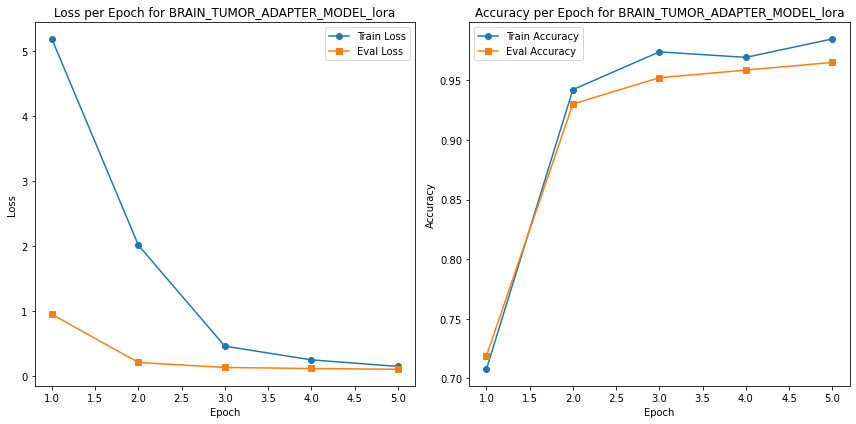

{'eval_loss': 0.1108180359005928, 'eval_accuracy': 0.9651245551601424, 'eval_f1': 0.9649185570365502, 'eval_precision': 0.9657770247353349, 'eval_recall': 0.9651245551601424, 'eval_runtime': 23.854, 'eval_samples_per_second': 58.9, 'eval_steps_per_second': 0.922, 'epoch': 5.0}

Training BRAIN_TUMOR_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 888,388/86,690,156 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.3712, 'grad_norm': 1.5553385019302368, 'learning_rate': 0.0011, 'epoch': 1.0}
{'eval_loss': 1.2312794923782349, 'eval_accuracy': 0.5800711743772242, 'eval_f1': 0.5043257748678689, 'eval_precision': 0.6501916474170876, 'eval_recall': 0.5800711743772242, 'eval_runtime': 23.8598, 'eval_samples_per_second': 58.886, 'eval_steps_per_second': 0.922, 'epoch': 1.0}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.7434, 'grad_norm': 2.3757565021514893, 'learning_rate': 0.0022, 'epoch': 2.0}
{'eval_loss': 0.5279483199119568, 'eval_accuracy': 0.8533807829181494, 'eval_f1': 0.8533670993318584, 'eval_precision': 0.854261681379119, 'eval_recall': 0.8533807829181494, 'eval_runtime': 23.5424, 'eval_samples_per_second': 59.679, 'eval_steps_per_second': 0.934, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 1.2403,

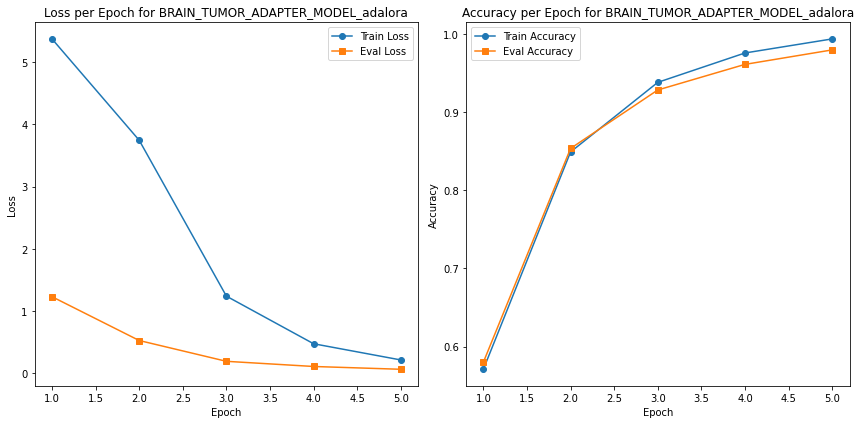

{'eval_loss': 0.06601300835609436, 'eval_accuracy': 0.9793594306049822, 'eval_f1': 0.9792774096005322, 'eval_precision': 0.97933320426175, 'eval_recall': 0.9793594306049822, 'eval_runtime': 23.8062, 'eval_samples_per_second': 59.018, 'eval_steps_per_second': 0.924, 'epoch': 5.0}

Training BRAIN_TUMOR_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 86,020/85,887,752 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.3128, 'grad_norm': 1.8917231559753418, 'learning_rate': 0.0011, 'epoch': 1.0}
{'eval_loss': 1.1547058820724487, 'eval_accuracy': 0.6669039145907474, 'eval_f1': 0.6050748429487881, 'eval_precision': 0.69734689587345, 'eval_recall': 0.6669039145907474, 'eval_runtime': 23.4215, 'eval_samples_per_second': 59.988, 'eval_steps_per_second': 0.939, 'epoch': 1.0}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.2169, 'grad_norm': 1.9374386072158813, 'learning_rate': 0.0022, 'epoch': 2.0}
{'eval_loss': 0.44810938835144043, 'eval_accuracy': 0.8576512455516014, 'eval_f1': 0.8561206824655673, 'eval_precision': 0.8562255227808214, 'eval_recall': 0.8576512455516014, 'eval_runtime': 24.104, 'eval_samples_per_second': 58.289, 'eval_steps_per_second': 0.913, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 1.2182, 'grad

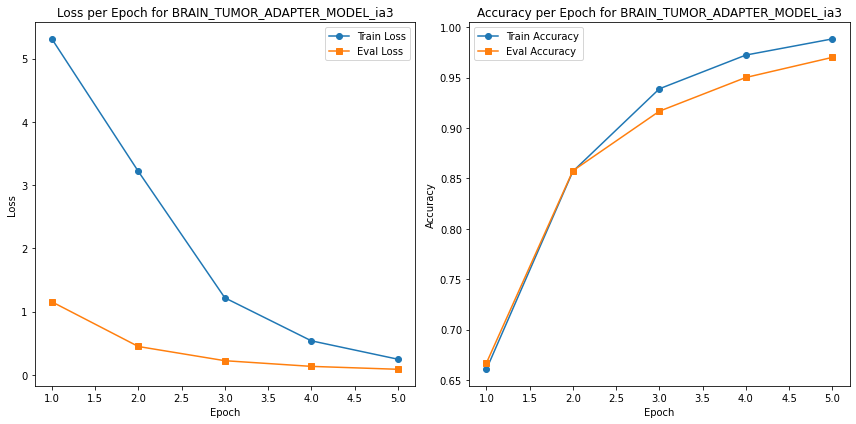

{'eval_loss': 0.08773478865623474, 'eval_accuracy': 0.9701067615658363, 'eval_f1': 0.9697762852614207, 'eval_precision': 0.9707402348037096, 'eval_recall': 0.9701067615658363, 'eval_runtime': 23.6977, 'eval_samples_per_second': 59.288, 'eval_steps_per_second': 0.928, 'epoch': 5.0}

Training BRAIN_TUMOR_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 1,772,548/87,574,280 (2.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.364, 'grad_norm': 1.5853321552276611, 'learning_rate': 0.0011, 'epoch': 1.0}
{'eval_loss': 1.2210413217544556, 'eval_accuracy': 0.6035587188612099, 'eval_f1': 0.5308818934018781, 'eval_precision': 0.6478881547335577, 'eval_recall': 0.6035587188612099, 'eval_runtime': 24.1564, 'eval_samples_per_second': 58.163, 'eval_steps_per_second': 0.911, 'epoch': 1.0}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.6931, 'grad_norm': 2.2828269004821777, 'learning_rate': 0.0022, 'epoch': 2.0}
{'eval_loss': 0.5200322866439819, 'eval_accuracy': 0.8427046263345196, 'eval_f1': 0.8413747198993284, 'eval_precision': 0.8460095571674373, 'eval_recall': 0.8427046263345196, 'eval_runtime': 23.9806, 'eval_samples_per_second': 58.589, 'eval_steps_per_second': 0.917, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 1.1541, 

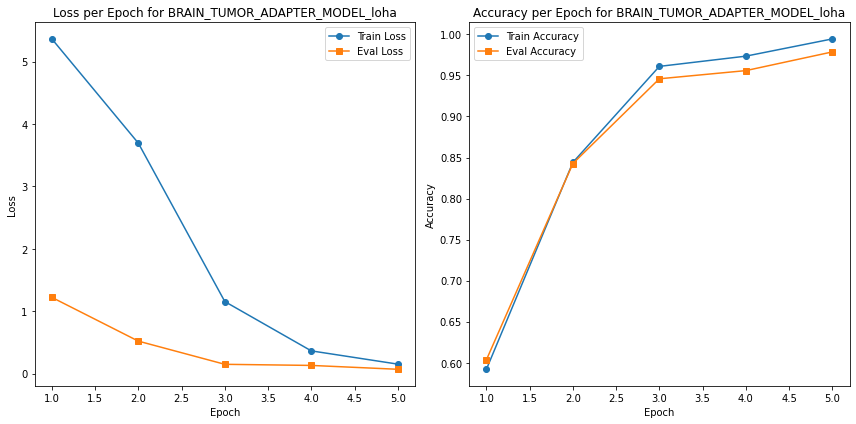

{'eval_loss': 0.06872140616178513, 'eval_accuracy': 0.9786476868327402, 'eval_f1': 0.9785034875733183, 'eval_precision': 0.978817596520462, 'eval_recall': 0.9786476868327402, 'eval_runtime': 23.3299, 'eval_samples_per_second': 60.223, 'eval_steps_per_second': 0.943, 'epoch': 5.0}

Training BRAIN_TUMOR_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 60,676/85,862,408 (0.07%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.2589, 'grad_norm': 1.652207851409912, 'learning_rate': 0.0011, 'epoch': 1.0}
{'eval_loss': 1.181645154953003, 'eval_accuracy': 0.6441281138790036, 'eval_f1': 0.57352973946548, 'eval_precision': 0.6395155258165, 'eval_recall': 0.6441281138790036, 'eval_runtime': 22.8912, 'eval_samples_per_second': 61.377, 'eval_steps_per_second': 0.961, 'epoch': 1.0}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.6715, 'grad_norm': 1.9994508028030396, 'learning_rate': 0.0022, 'epoch': 2.0}
{'eval_loss': 0.5949333310127258, 'eval_accuracy': 0.8284697508896797, 'eval_f1': 0.8274156204869217, 'eval_precision': 0.829043007254406, 'eval_recall': 0.8284697508896797, 'eval_runtime': 22.8387, 'eval_samples_per_second': 61.518, 'eval_steps_per_second': 0.963, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 1.5469, 'grad_norm

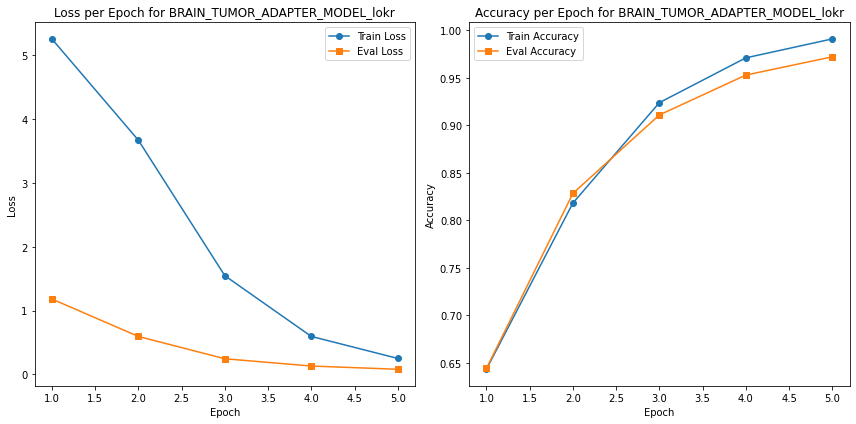

{'eval_loss': 0.07997327297925949, 'eval_accuracy': 0.9722419928825623, 'eval_f1': 0.9719627399521409, 'eval_precision': 0.9723418863490494, 'eval_recall': 0.9722419928825623, 'eval_runtime': 22.8241, 'eval_samples_per_second': 61.558, 'eval_steps_per_second': 0.964, 'epoch': 5.0}

Training DIABETIC_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 888,581/86,691,082 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.7664, 'grad_norm': 1.5079641342163086, 'learning_rate': 0.00155, 'epoch': 0.992}
{'eval_loss': 1.0376619100570679, 'eval_accuracy': 0.593, 'eval_f1': 0.5757449936857181, 'eval_precision': 0.5913903783442456, 'eval_recall': 0.593, 'eval_runtime': 106.0279, 'eval_samples_per_second': 18.863, 'eval_steps_per_second': 0.302, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.426, 'grad_norm': 4.230576992034912, 'learning_rate': 0.0031, 'epoch': 1.984}
{'eval_loss': 0.8195310235023499, 'eval_accuracy': 0.6455, 'eval_f1': 0.6247418329681098, 'eval_precision': 0.6771676988002974, 'eval_recall': 0.6455, 'eval_runtime': 106.1106, 'eval_samples_per_second': 18.848, 'eval_steps_per_second': 0.302, 'epoch': 1.984}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 2.623, 'grad_norm': 2.261575698852539, 'learning_r

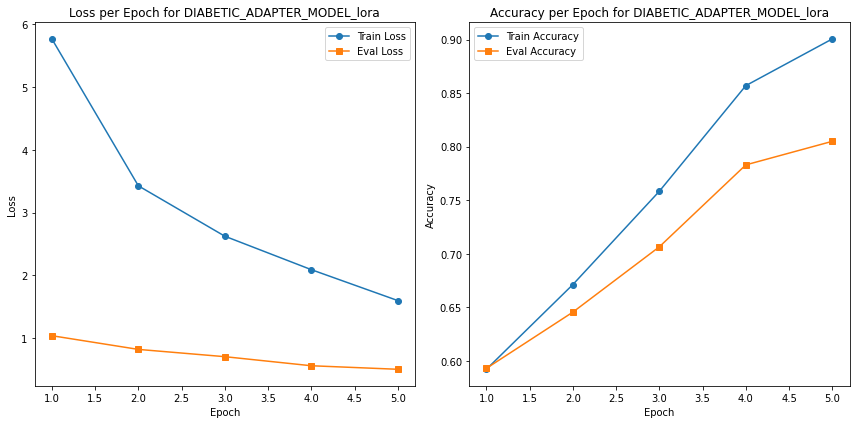

{'eval_loss': 0.5027204155921936, 'eval_accuracy': 0.805, 'eval_f1': 0.804969605832847, 'eval_precision': 0.8175292975134669, 'eval_recall': 0.805, 'eval_runtime': 105.8679, 'eval_samples_per_second': 18.891, 'eval_steps_per_second': 0.302, 'epoch': 4.96}

Training DIABETIC_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 889,157/86,691,694 (1.03%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.2237, 'grad_norm': 1.8588042259216309, 'learning_rate': 0.00155, 'epoch': 0.992}
{'eval_loss': 1.3750019073486328, 'eval_accuracy': 0.4625, 'eval_f1': 0.4311424688664357, 'eval_precision': 0.46766390596280344, 'eval_recall': 0.4625, 'eval_runtime': 106.715, 'eval_samples_per_second': 18.742, 'eval_steps_per_second': 0.3, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.222, 'grad_norm': 2.2232227325439453, 'learning_rate': 0.0031, 'epoch': 1.984}
{'eval_loss': 0.8116155862808228, 'eval_accuracy': 0.658, 'eval_f1': 0.6501521795171832, 'eval_precision': 0.6577598649179436, 'eval_recall': 0.658, 'eval_runtime': 106.5128, 'eval_samples_per_second': 18.777, 'eval_steps_per_second': 0.3, 'epoch': 1.984}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 2.9232, 'grad_norm': 1.2472771406173706, 'learning

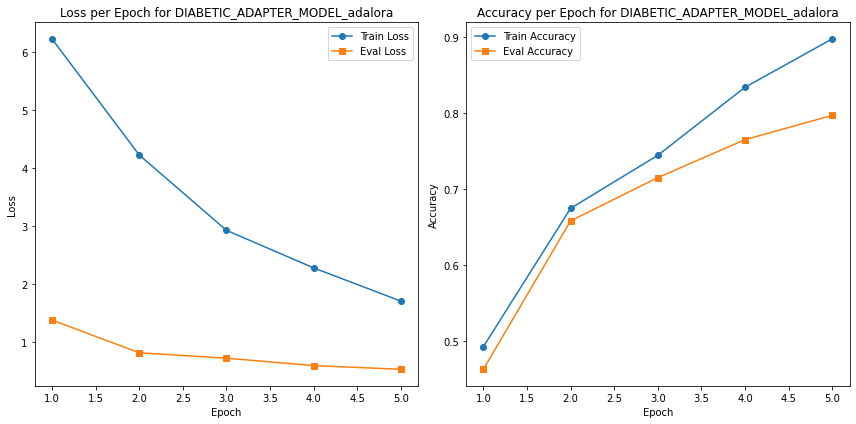

{'eval_loss': 0.5266395211219788, 'eval_accuracy': 0.797, 'eval_f1': 0.7957517899557531, 'eval_precision': 0.7988849739998646, 'eval_recall': 0.797, 'eval_runtime': 106.9421, 'eval_samples_per_second': 18.702, 'eval_steps_per_second': 0.299, 'epoch': 4.96}

Training DIABETIC_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 86,789/85,889,290 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.0716, 'grad_norm': 1.9058188199996948, 'learning_rate': 0.00155, 'epoch': 0.992}
{'eval_loss': 1.2617218494415283, 'eval_accuracy': 0.5205, 'eval_f1': 0.5116609576178803, 'eval_precision': 0.5390616236641413, 'eval_recall': 0.5205, 'eval_runtime': 106.3005, 'eval_samples_per_second': 18.815, 'eval_steps_per_second': 0.301, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.0078, 'grad_norm': 1.347066879272461, 'learning_rate': 0.00305, 'epoch': 1.984}
{'eval_loss': 0.8167217969894409, 'eval_accuracy': 0.6715, 'eval_f1': 0.6638967373315295, 'eval_precision': 0.6655721513662864, 'eval_recall': 0.6715, 'eval_runtime': 106.4037, 'eval_samples_per_second': 18.796, 'eval_steps_per_second': 0.301, 'epoch': 1.984}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 2.9735, 'grad_norm': 2.103079319000244, 'learnin

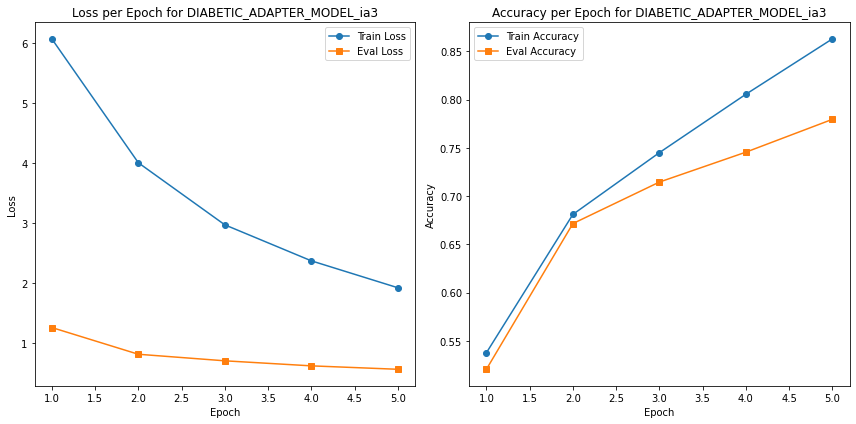

{'eval_loss': 0.5662679672241211, 'eval_accuracy': 0.7795, 'eval_f1': 0.7795677067755754, 'eval_precision': 0.7799109443868013, 'eval_recall': 0.7795, 'eval_runtime': 106.2714, 'eval_samples_per_second': 18.82, 'eval_steps_per_second': 0.301, 'epoch': 4.96}

Training DIABETIC_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 1,773,317/87,575,818 (2.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.2029, 'grad_norm': 1.806813359260559, 'learning_rate': 0.00155, 'epoch': 0.992}
{'eval_loss': 1.3580440282821655, 'eval_accuracy': 0.478, 'eval_f1': 0.4519678600361299, 'eval_precision': 0.4775079430333568, 'eval_recall': 0.478, 'eval_runtime': 105.7173, 'eval_samples_per_second': 18.918, 'eval_steps_per_second': 0.303, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.157, 'grad_norm': 1.2058874368667603, 'learning_rate': 0.0031, 'epoch': 1.984}
{'eval_loss': 0.7962564826011658, 'eval_accuracy': 0.665, 'eval_f1': 0.6600114389643014, 'eval_precision': 0.6645658460943216, 'eval_recall': 0.665, 'eval_runtime': 106.0492, 'eval_samples_per_second': 18.859, 'eval_steps_per_second': 0.302, 'epoch': 1.984}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 2.845, 'grad_norm': 1.1451078653335571, 'learning_

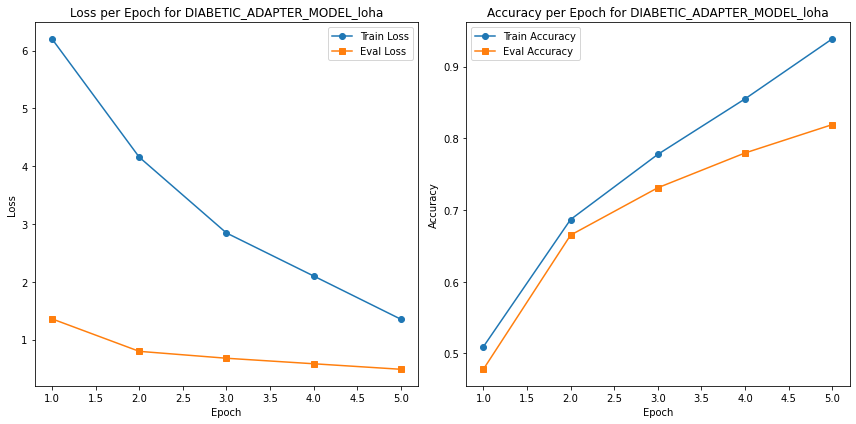

{'eval_loss': 0.48560184240341187, 'eval_accuracy': 0.819, 'eval_f1': 0.8176848534682865, 'eval_precision': 0.8196495034853263, 'eval_recall': 0.819, 'eval_runtime': 105.9893, 'eval_samples_per_second': 18.87, 'eval_steps_per_second': 0.302, 'epoch': 4.96}

Training DIABETIC_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 61,445/85,863,946 (0.07%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.1847, 'grad_norm': 1.789076805114746, 'learning_rate': 0.00155, 'epoch': 0.992}
{'eval_loss': 1.359826922416687, 'eval_accuracy': 0.494, 'eval_f1': 0.47366505386485425, 'eval_precision': 0.49232806100657434, 'eval_recall': 0.494, 'eval_runtime': 107.3552, 'eval_samples_per_second': 18.63, 'eval_steps_per_second': 0.298, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.3688, 'grad_norm': 1.2135651111602783, 'learning_rate': 0.0031, 'epoch': 1.984}
{'eval_loss': 0.880048394203186, 'eval_accuracy': 0.646, 'eval_f1': 0.6353862043843728, 'eval_precision': 0.6398366200685882, 'eval_recall': 0.646, 'eval_runtime': 108.078, 'eval_samples_per_second': 18.505, 'eval_steps_per_second': 0.296, 'epoch': 1.984}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 3.0962, 'grad_norm': 1.2100813388824463, 'learning_rat

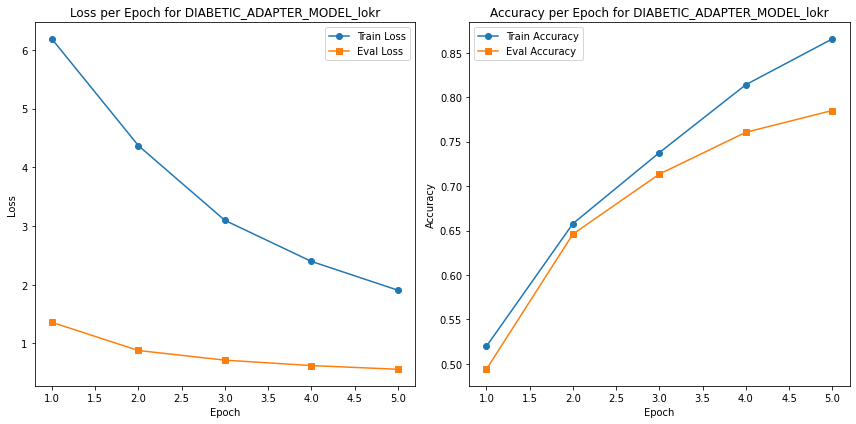

{'eval_loss': 0.5601276159286499, 'eval_accuracy': 0.785, 'eval_f1': 0.7847784452464452, 'eval_precision': 0.7861688247469281, 'eval_recall': 0.785, 'eval_runtime': 107.6724, 'eval_samples_per_second': 18.575, 'eval_steps_per_second': 0.297, 'epoch': 4.96}

Training SKIN_CANCER_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 891,657/86,697,234 (1.03%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.4887, 'grad_norm': 4.71319580078125, 'learning_rate': 0.0028000000000000004, 'epoch': 0.9955555555555555}
{'eval_loss': 0.8800243735313416, 'eval_accuracy': 0.6713888888888889, 'eval_f1': 0.6617419650091774, 'eval_precision': 0.6698941776752395, 'eval_recall': 0.6713888888888889, 'eval_runtime': 56.7238, 'eval_samples_per_second': 63.465, 'eval_steps_per_second': 1.005, 'epoch': 0.9955555555555555}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 2.7492, 'grad_norm': 3.015235424041748, 'learning_rate': 0.004941463414634147, 'epoch': 1.991111111111111}
{'eval_loss': 0.5442721843719482, 'eval_accuracy': 0.7855555555555556, 'eval_f1': 0.7823258895634184, 'eval_precision': 0.7893450174205261, 'eval_recall': 0.7855555555555556, 'eval_runtime': 56.3122, 'eval_samples_per_second': 63.929, 'eval_steps_per_second': 1.012, 'epoch': 1.9

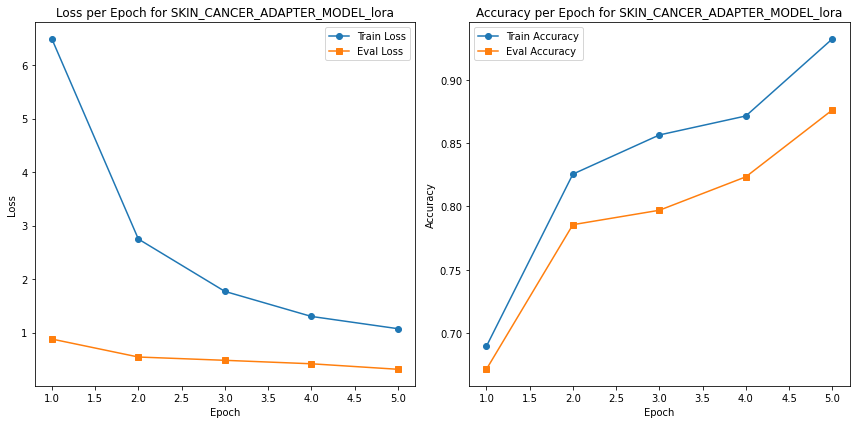

{'eval_loss': 0.3149990439414978, 'eval_accuracy': 0.8761111111111111, 'eval_f1': 0.8756777255108882, 'eval_precision': 0.8775066290201471, 'eval_recall': 0.8761111111111111, 'eval_runtime': 56.1162, 'eval_samples_per_second': 64.153, 'eval_steps_per_second': 1.016, 'epoch': 4.977777777777778}

Training SKIN_CANCER_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 892,233/86,697,846 (1.03%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 7.541, 'grad_norm': 1.822726845741272, 'learning_rate': 0.0028000000000000004, 'epoch': 0.9955555555555555}
{'eval_loss': 1.2126680612564087, 'eval_accuracy': 0.5802777777777778, 'eval_f1': 0.5618309802877952, 'eval_precision': 0.5968055973127325, 'eval_recall': 0.5802777777777778, 'eval_runtime': 56.274, 'eval_samples_per_second': 63.973, 'eval_steps_per_second': 1.013, 'epoch': 0.9955555555555555}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.3366, 'grad_norm': 1.3960288763046265, 'learning_rate': 0.004941463414634147, 'epoch': 1.991111111111111}
{'eval_loss': 0.593479573726654, 'eval_accuracy': 0.7858333333333334, 'eval_f1': 0.7831870679985095, 'eval_precision': 0.7862439826764472, 'eval_recall': 0.7858333333333334, 'eval_runtime': 56.3557, 'eval_samples_per_second': 63.88, 'eval_steps_per_second': 1.011, 'epoch': 1.

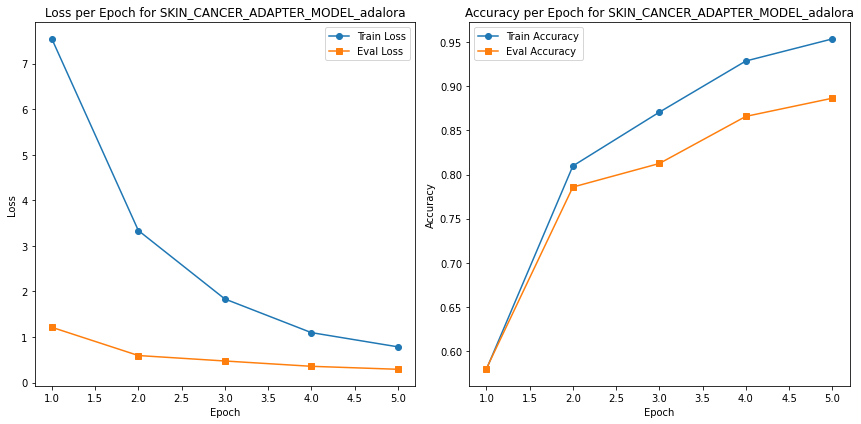

{'eval_loss': 0.291583389043808, 'eval_accuracy': 0.8863888888888889, 'eval_f1': 0.8855877768377736, 'eval_precision': 0.8854989641462337, 'eval_recall': 0.8863888888888889, 'eval_runtime': 56.3871, 'eval_samples_per_second': 63.844, 'eval_steps_per_second': 1.011, 'epoch': 4.977777777777778}

Training SKIN_CANCER_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 89,865/85,895,442 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 7.459, 'grad_norm': 1.3439416885375977, 'learning_rate': 0.0028000000000000004, 'epoch': 0.9955555555555555}
{'eval_loss': 1.2477099895477295, 'eval_accuracy': 0.5755555555555556, 'eval_f1': 0.5642778183288384, 'eval_precision': 0.5799196369846149, 'eval_recall': 0.5755555555555556, 'eval_runtime': 56.9097, 'eval_samples_per_second': 63.258, 'eval_steps_per_second': 1.002, 'epoch': 0.9955555555555555}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.5373, 'grad_norm': 1.4803708791732788, 'learning_rate': 0.004946341463414634, 'epoch': 1.991111111111111}
{'eval_loss': 0.6687509417533875, 'eval_accuracy': 0.7519444444444444, 'eval_f1': 0.7510473328523669, 'eval_precision': 0.7539615666415315, 'eval_recall': 0.7519444444444444, 'eval_runtime': 57.2817, 'eval_samples_per_second': 62.847, 'eval_steps_per_second': 0.995, 'epoch': 1.9

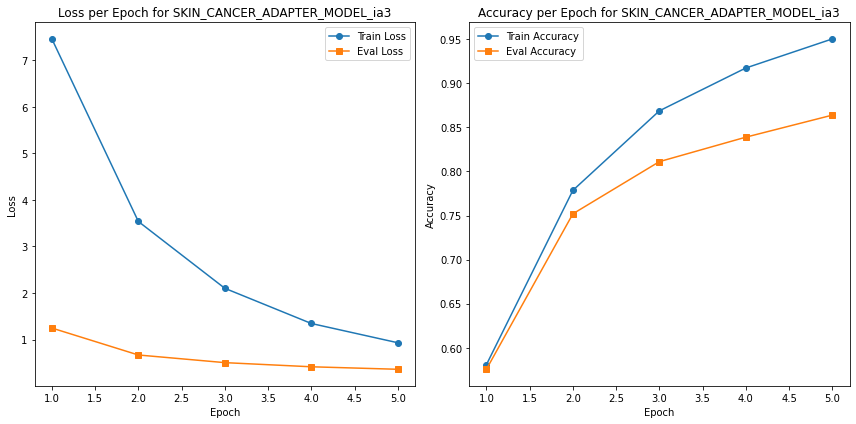

{'eval_loss': 0.36163437366485596, 'eval_accuracy': 0.8638888888888889, 'eval_f1': 0.8627214102869584, 'eval_precision': 0.8626868384738294, 'eval_recall': 0.8638888888888889, 'eval_runtime': 56.6749, 'eval_samples_per_second': 63.52, 'eval_steps_per_second': 1.006, 'epoch': 4.977777777777778}

Training SKIN_CANCER_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 1,776,393/87,581,970 (2.03%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 7.5482, 'grad_norm': 1.4603439569473267, 'learning_rate': 0.0028000000000000004, 'epoch': 0.9955555555555555}
{'eval_loss': 1.2033847570419312, 'eval_accuracy': 0.5777777777777777, 'eval_f1': 0.5608597363062239, 'eval_precision': 0.5851414148152423, 'eval_recall': 0.5777777777777777, 'eval_runtime': 56.4086, 'eval_samples_per_second': 63.82, 'eval_steps_per_second': 1.01, 'epoch': 0.9955555555555555}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.1285, 'grad_norm': 0.8821320533752441, 'learning_rate': 0.004941463414634147, 'epoch': 1.991111111111111}
{'eval_loss': 0.5288494825363159, 'eval_accuracy': 0.7975, 'eval_f1': 0.7966028161513057, 'eval_precision': 0.8053543921852946, 'eval_recall': 0.7975, 'eval_runtime': 56.8494, 'eval_samples_per_second': 63.325, 'eval_steps_per_second': 1.003, 'epoch': 1.991111111111111}
Start

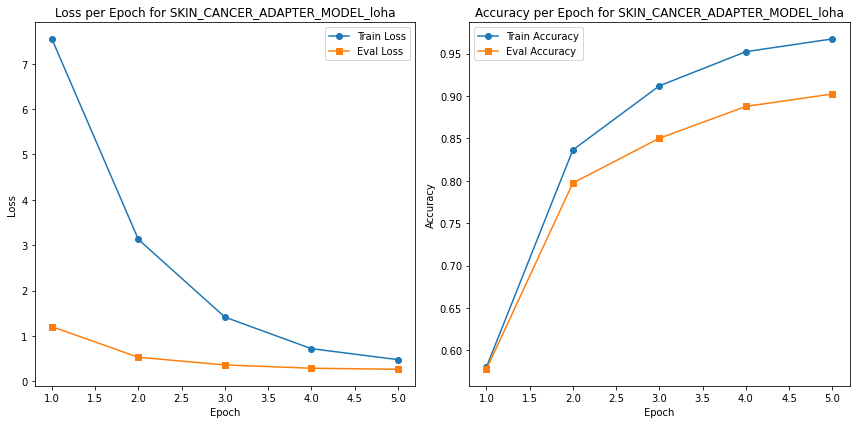

{'eval_loss': 0.26392123103141785, 'eval_accuracy': 0.9025, 'eval_f1': 0.9014571595670519, 'eval_precision': 0.9025420514381562, 'eval_recall': 0.9025, 'eval_runtime': 56.351, 'eval_samples_per_second': 63.885, 'eval_steps_per_second': 1.012, 'epoch': 4.977777777777778}

Training SKIN_CANCER_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 64,521/85,870,098 (0.08%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 7.6109, 'grad_norm': 1.2961549758911133, 'learning_rate': 0.0028000000000000004, 'epoch': 0.9955555555555555}
{'eval_loss': 1.3201059103012085, 'eval_accuracy': 0.5502777777777778, 'eval_f1': 0.5387609566874069, 'eval_precision': 0.5501608439330351, 'eval_recall': 0.5502777777777778, 'eval_runtime': 56.6287, 'eval_samples_per_second': 63.572, 'eval_steps_per_second': 1.007, 'epoch': 0.9955555555555555}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.6437, 'grad_norm': 1.5545181035995483, 'learning_rate': 0.004941463414634147, 'epoch': 1.991111111111111}
{'eval_loss': 0.666967511177063, 'eval_accuracy': 0.7480555555555556, 'eval_f1': 0.7479783202717427, 'eval_precision': 0.7528516283808262, 'eval_recall': 0.7480555555555556, 'eval_runtime': 57.2955, 'eval_samples_per_second': 62.832, 'eval_steps_per_second': 0.995, 'epoch': 1.

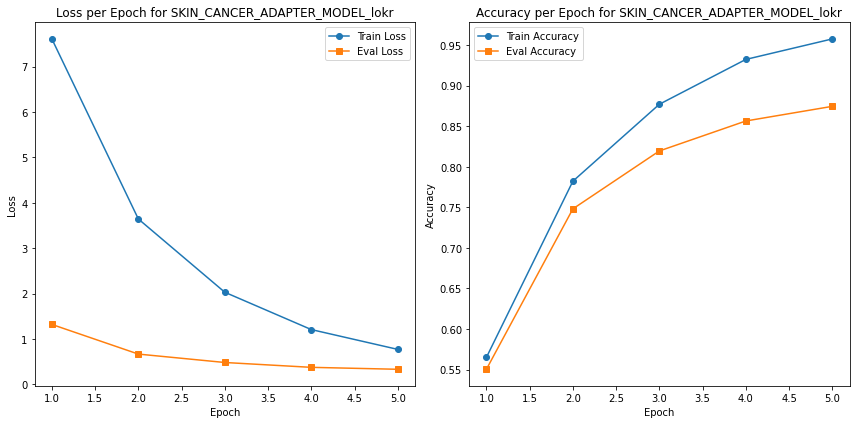

{'eval_loss': 0.3320521414279938, 'eval_accuracy': 0.8744444444444445, 'eval_f1': 0.8740933054208584, 'eval_precision': 0.8744602732301986, 'eval_recall': 0.8744444444444445, 'eval_runtime': 58.3487, 'eval_samples_per_second': 61.698, 'eval_steps_per_second': 0.977, 'epoch': 4.977777777777778}

Training RETINA_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 887,812/86,689,544 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 3.0951, 'grad_norm': 1.7162537574768066, 'learning_rate': 0.0031, 'epoch': 0.992}
{'eval_loss': 0.2572811245918274, 'eval_accuracy': 0.91125, 'eval_f1': 0.9112065997303227, 'eval_precision': 0.9116040360369488, 'eval_recall': 0.91125, 'eval_runtime': 72.2018, 'eval_samples_per_second': 55.4, 'eval_steps_per_second': 0.873, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 0.962, 'grad_norm': 2.4359400272369385, 'learning_rate': 0.004891304347826087, 'epoch': 2.0}
{'eval_loss': 0.24221746623516083, 'eval_accuracy': 0.91225, 'eval_f1': 0.9127078336947811, 'eval_precision': 0.9159685159864155, 'eval_recall': 0.91225, 'eval_runtime': 71.7126, 'eval_samples_per_second': 55.778, 'eval_steps_per_second': 0.879, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.8116, 'grad_norm': 2.43441653251647

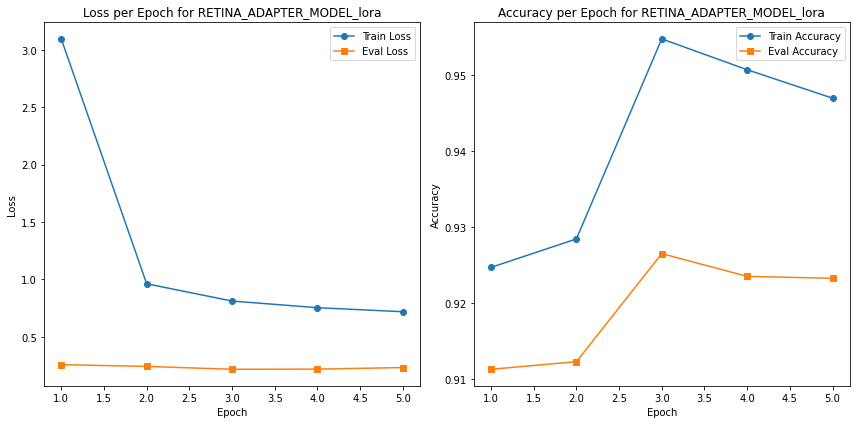

{'eval_loss': 0.21710877120494843, 'eval_accuracy': 0.9265, 'eval_f1': 0.9263362046569106, 'eval_precision': 0.9269513949690659, 'eval_recall': 0.9265, 'eval_runtime': 70.7116, 'eval_samples_per_second': 56.568, 'eval_steps_per_second': 0.891, 'epoch': 4.96}

Training RETINA_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 888,388/86,690,156 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.0051, 'grad_norm': 1.1943351030349731, 'learning_rate': 0.0031, 'epoch': 0.992}
{'eval_loss': 0.35072076320648193, 'eval_accuracy': 0.8745, 'eval_f1': 0.8729912168518076, 'eval_precision': 0.8773461271083861, 'eval_recall': 0.8745, 'eval_runtime': 71.7243, 'eval_samples_per_second': 55.769, 'eval_steps_per_second': 0.878, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 0.9875, 'grad_norm': 1.528616189956665, 'learning_rate': 0.004891304347826087, 'epoch': 2.0}
{'eval_loss': 0.21289420127868652, 'eval_accuracy': 0.9265, 'eval_f1': 0.9264665972648285, 'eval_precision': 0.9270953677534959, 'eval_recall': 0.9265, 'eval_runtime': 71.157, 'eval_samples_per_second': 56.214, 'eval_steps_per_second': 0.885, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.6962, 'grad_norm': 0.8724307417869

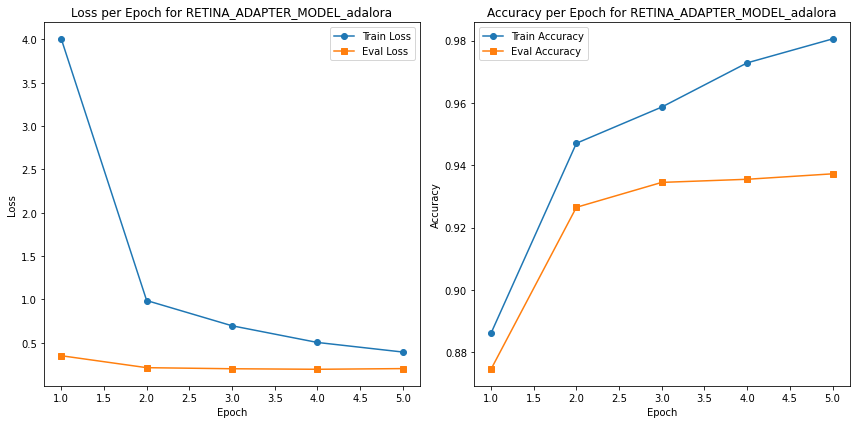

{'eval_loss': 0.20229165256023407, 'eval_accuracy': 0.93725, 'eval_f1': 0.9374439234661884, 'eval_precision': 0.9381006261121362, 'eval_recall': 0.93725, 'eval_runtime': 70.2745, 'eval_samples_per_second': 56.92, 'eval_steps_per_second': 0.896, 'epoch': 4.96}

Training RETINA_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 86,020/85,887,752 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 3.8929, 'grad_norm': 1.2720853090286255, 'learning_rate': 0.0031, 'epoch': 0.992}
{'eval_loss': 0.41225147247314453, 'eval_accuracy': 0.8505, 'eval_f1': 0.8498270552452398, 'eval_precision': 0.8502623829477866, 'eval_recall': 0.8505, 'eval_runtime': 69.9509, 'eval_samples_per_second': 57.183, 'eval_steps_per_second': 0.901, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.1261, 'grad_norm': 1.2872493267059326, 'learning_rate': 0.004891304347826087, 'epoch': 2.0}
{'eval_loss': 0.25257667899131775, 'eval_accuracy': 0.913, 'eval_f1': 0.9127180607229681, 'eval_precision': 0.9138461216410645, 'eval_recall': 0.913, 'eval_runtime': 69.7907, 'eval_samples_per_second': 57.314, 'eval_steps_per_second': 0.903, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.7522, 'grad_norm': 1.1868199110031128, 

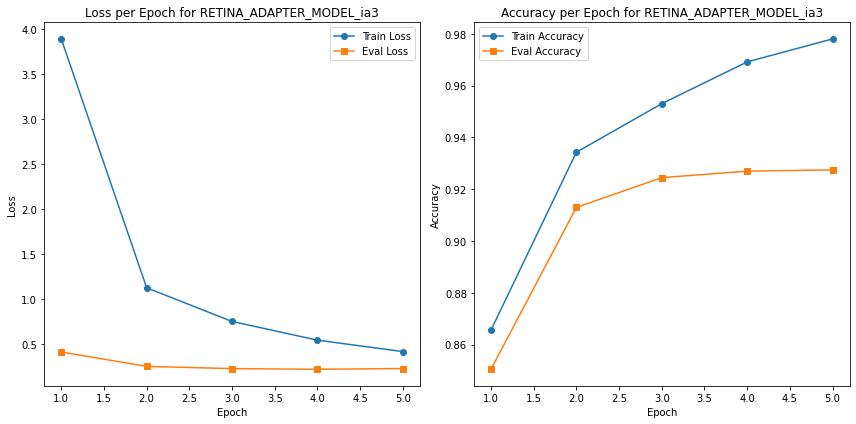

{'eval_loss': 0.22862088680267334, 'eval_accuracy': 0.9275, 'eval_f1': 0.927663706282013, 'eval_precision': 0.9283870755891366, 'eval_recall': 0.9275, 'eval_runtime': 71.825, 'eval_samples_per_second': 55.691, 'eval_steps_per_second': 0.877, 'epoch': 4.96}

Training RETINA_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 1,772,548/87,574,280 (2.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.0247, 'grad_norm': 0.7262880206108093, 'learning_rate': 0.0031, 'epoch': 0.992}
{'eval_loss': 0.36784082651138306, 'eval_accuracy': 0.86575, 'eval_f1': 0.8657876112100998, 'eval_precision': 0.87477616738754, 'eval_recall': 0.86575, 'eval_runtime': 71.4376, 'eval_samples_per_second': 55.993, 'eval_steps_per_second': 0.882, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 0.9623, 'grad_norm': 0.6743021607398987, 'learning_rate': 0.004891304347826087, 'epoch': 2.0}
{'eval_loss': 0.21612054109573364, 'eval_accuracy': 0.9215, 'eval_f1': 0.9211649356804122, 'eval_precision': 0.9237202173360234, 'eval_recall': 0.9215, 'eval_runtime': 72.6704, 'eval_samples_per_second': 55.043, 'eval_steps_per_second': 0.867, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.618, 'grad_norm': 0.4841448962688

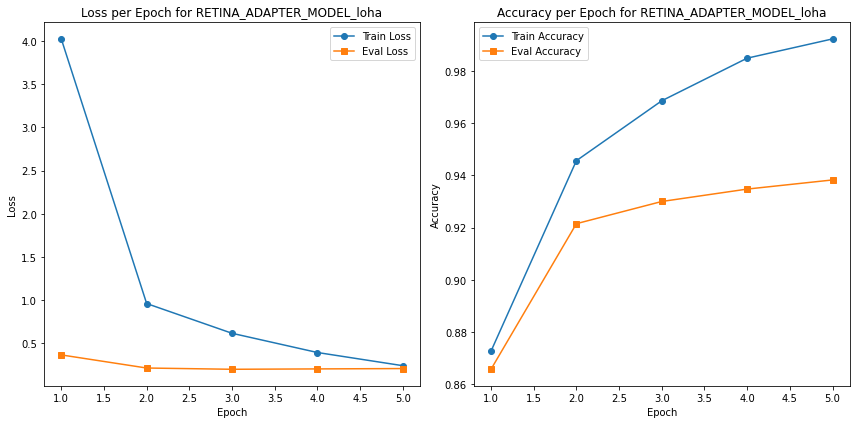

{'eval_loss': 0.2098904699087143, 'eval_accuracy': 0.93825, 'eval_f1': 0.9382476860321985, 'eval_precision': 0.9383631986383062, 'eval_recall': 0.93825, 'eval_runtime': 71.3276, 'eval_samples_per_second': 56.079, 'eval_steps_per_second': 0.883, 'epoch': 4.96}

Training RETINA_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 60,676/85,862,408 (0.07%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 4.1907, 'grad_norm': 0.8087812662124634, 'learning_rate': 0.0031, 'epoch': 0.992}
{'eval_loss': 0.5078035593032837, 'eval_accuracy': 0.81325, 'eval_f1': 0.8121146142224736, 'eval_precision': 0.8129449359848802, 'eval_recall': 0.81325, 'eval_runtime': 71.5953, 'eval_samples_per_second': 55.87, 'eval_steps_per_second': 0.88, 'epoch': 0.992}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 1.2476, 'grad_norm': 1.431434988975525, 'learning_rate': 0.004891304347826087, 'epoch': 2.0}
{'eval_loss': 0.25463634729385376, 'eval_accuracy': 0.91075, 'eval_f1': 0.9107042614782059, 'eval_precision': 0.9134794578384492, 'eval_recall': 0.91075, 'eval_runtime': 69.9163, 'eval_samples_per_second': 57.211, 'eval_steps_per_second': 0.901, 'epoch': 2.0}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss': 0.7745, 'grad_norm': 1.286998629570007

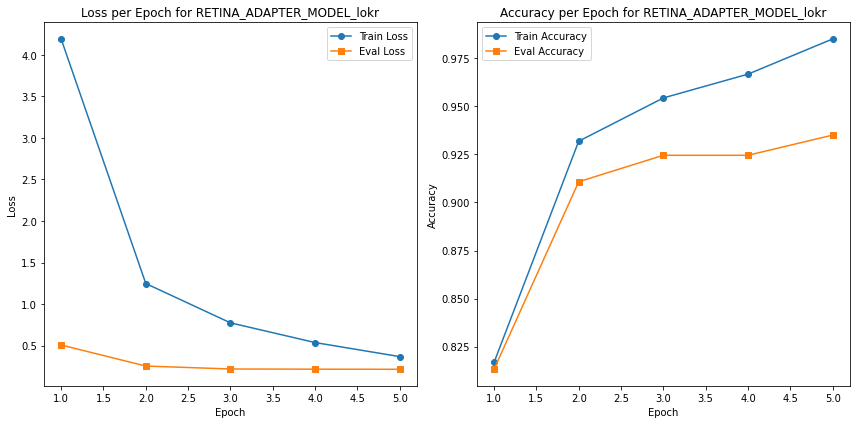

{'eval_loss': 0.21567751467227936, 'eval_accuracy': 0.935, 'eval_f1': 0.9350697145250578, 'eval_precision': 0.9351876741204043, 'eval_recall': 0.935, 'eval_runtime': 72.6155, 'eval_samples_per_second': 55.085, 'eval_steps_per_second': 0.868, 'epoch': 4.96}

Training KIDNEY_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 887,812/86,689,544 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.4632, 'grad_norm': 2.1301002502441406, 'learning_rate': 0.0009, 'epoch': 0.972972972972973}
{'eval_loss': 1.2066339254379272, 'eval_accuracy': 0.5739795918367347, 'eval_f1': 0.5461699100123836, 'eval_precision': 0.5981761365383934, 'eval_recall': 0.5739795918367347, 'eval_runtime': 23.2315, 'eval_samples_per_second': 50.621, 'eval_steps_per_second': 0.818, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 3.1481, 'grad_norm': 2.844930648803711, 'learning_rate': 0.0018, 'epoch': 1.9594594594594594}
{'eval_loss': 0.31311652064323425, 'eval_accuracy': 0.9098639455782312, 'eval_f1': 0.9091969161840512, 'eval_precision': 0.9140234424454656, 'eval_recall': 0.9098639455782312, 'eval_runtime': 22.2222, 'eval_samples_per_second': 52.92, 'eval_steps_per_second': 0.855, 'epoch': 1.9594594594594594}
Starting Ep

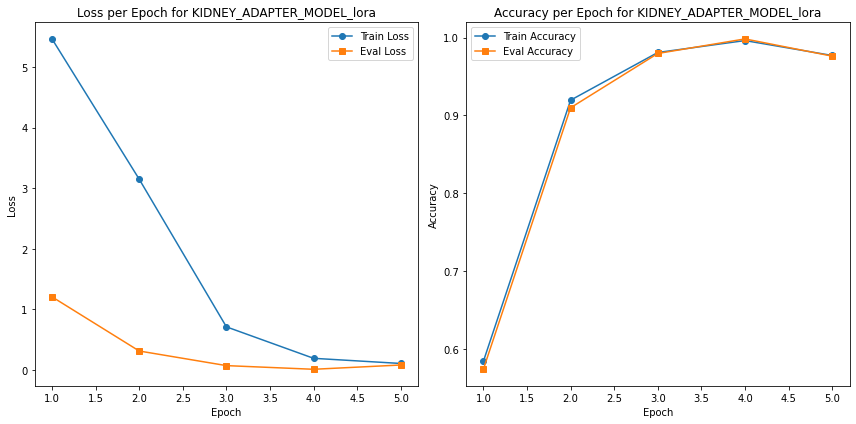

{'eval_loss': 0.011473137885332108, 'eval_accuracy': 0.9982993197278912, 'eval_f1': 0.998299222248593, 'eval_precision': 0.9983020805724887, 'eval_recall': 0.9982993197278912, 'eval_runtime': 21.8374, 'eval_samples_per_second': 53.853, 'eval_steps_per_second': 0.87, 'epoch': 4.918918918918919}

Training KIDNEY_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 888,388/86,690,156 (1.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.5623, 'grad_norm': 1.3260802030563354, 'learning_rate': 0.0009, 'epoch': 0.972972972972973}
{'eval_loss': 1.3226900100708008, 'eval_accuracy': 0.45408163265306123, 'eval_f1': 0.41281814083072627, 'eval_precision': 0.48231387436709006, 'eval_recall': 0.45408163265306123, 'eval_runtime': 21.8599, 'eval_samples_per_second': 53.797, 'eval_steps_per_second': 0.869, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.9229, 'grad_norm': 1.3136597871780396, 'learning_rate': 0.0018, 'epoch': 1.9594594594594594}
{'eval_loss': 1.0316197872161865, 'eval_accuracy': 0.6284013605442177, 'eval_f1': 0.6191709589994436, 'eval_precision': 0.6430326608201191, 'eval_recall': 0.6284013605442177, 'eval_runtime': 22.0578, 'eval_samples_per_second': 53.315, 'eval_steps_per_second': 0.861, 'epoch': 1.9594594594594594}
Sta

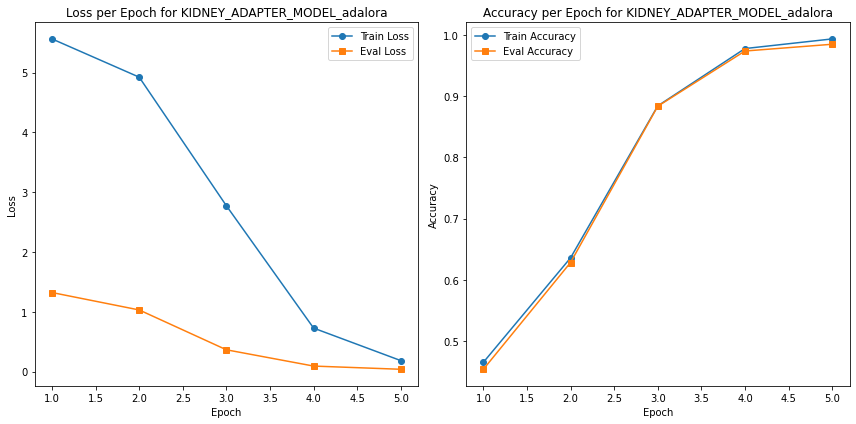

{'eval_loss': 0.04000446945428848, 'eval_accuracy': 0.9846938775510204, 'eval_f1': 0.9846487277494635, 'eval_precision': 0.9851830761321729, 'eval_recall': 0.9846938775510204, 'eval_runtime': 21.7958, 'eval_samples_per_second': 53.955, 'eval_steps_per_second': 0.872, 'epoch': 4.918918918918919}

Training KIDNEY_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 86,020/85,887,752 (0.10%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.5412, 'grad_norm': 1.3552238941192627, 'learning_rate': 0.0009, 'epoch': 0.972972972972973}
{'eval_loss': 1.3025484085083008, 'eval_accuracy': 0.49489795918367346, 'eval_f1': 0.45930847973748673, 'eval_precision': 0.5229867657637923, 'eval_recall': 0.49489795918367346, 'eval_runtime': 22.1775, 'eval_samples_per_second': 53.027, 'eval_steps_per_second': 0.857, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.6149, 'grad_norm': 1.3935726881027222, 'learning_rate': 0.0018, 'epoch': 1.9594594594594594}
{'eval_loss': 0.9117626547813416, 'eval_accuracy': 0.701530612244898, 'eval_f1': 0.7023798147083751, 'eval_precision': 0.7178271616657191, 'eval_recall': 0.701530612244898, 'eval_runtime': 22.0331, 'eval_samples_per_second': 53.374, 'eval_steps_per_second': 0.862, 'epoch': 1.9594594594594594}
Starting Ep

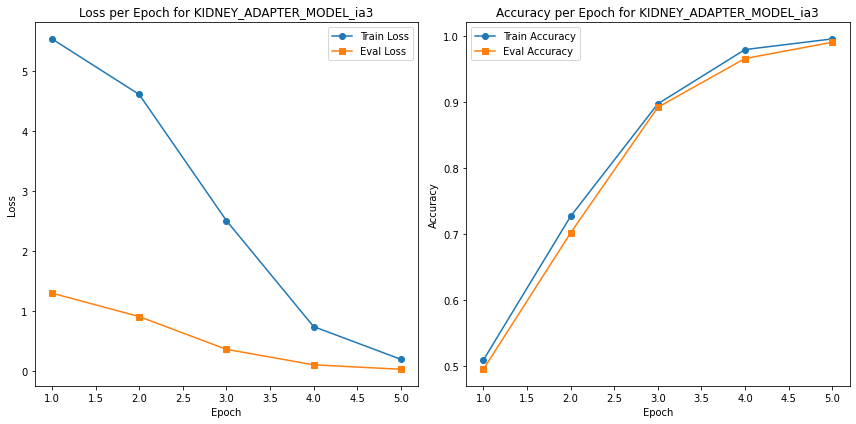

{'eval_loss': 0.033039990812540054, 'eval_accuracy': 0.9906462585034014, 'eval_f1': 0.9906358555228233, 'eval_precision': 0.9907382001872481, 'eval_recall': 0.9906462585034014, 'eval_runtime': 21.7012, 'eval_samples_per_second': 54.191, 'eval_steps_per_second': 0.876, 'epoch': 4.918918918918919}

Training KIDNEY_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 1,772,548/87,574,280 (2.02%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.5599, 'grad_norm': 1.325411319732666, 'learning_rate': 0.0009, 'epoch': 0.972972972972973}
{'eval_loss': 1.3199533224105835, 'eval_accuracy': 0.45918367346938777, 'eval_f1': 0.41761901730342366, 'eval_precision': 0.4885052298749959, 'eval_recall': 0.45918367346938777, 'eval_runtime': 21.7631, 'eval_samples_per_second': 54.036, 'eval_steps_per_second': 0.873, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.8889, 'grad_norm': 1.1994640827178955, 'learning_rate': 0.0018, 'epoch': 1.9594594594594594}
{'eval_loss': 1.0253233909606934, 'eval_accuracy': 0.6284013605442177, 'eval_f1': 0.6223861235482717, 'eval_precision': 0.6427296195377042, 'eval_recall': 0.6284013605442177, 'eval_runtime': 21.6997, 'eval_samples_per_second': 54.194, 'eval_steps_per_second': 0.876, 'epoch': 1.9594594594594594}
Starti

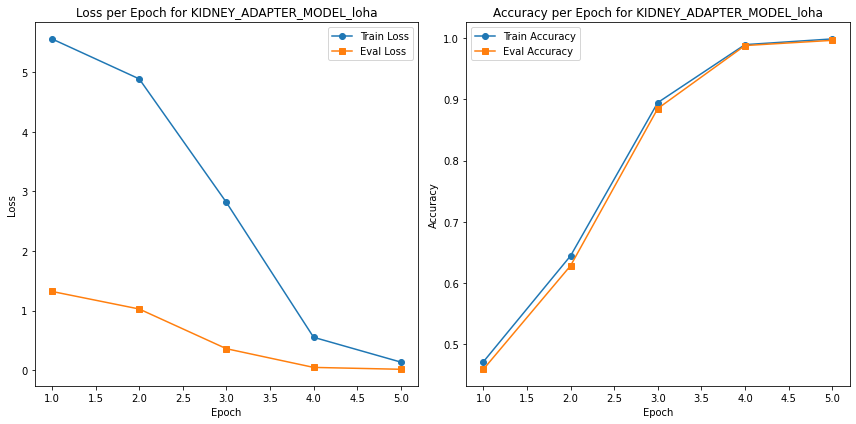

{'eval_loss': 0.013415765948593616, 'eval_accuracy': 0.9965986394557823, 'eval_f1': 0.9965951310660186, 'eval_precision': 0.9966007424054935, 'eval_recall': 0.9965986394557823, 'eval_runtime': 21.6031, 'eval_samples_per_second': 54.437, 'eval_steps_per_second': 0.88, 'epoch': 4.918918918918919}

Training KIDNEY_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 60,676/85,862,408 (0.07%)
Number of Training Epochs:  5
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.5187, 'grad_norm': 1.4665330648422241, 'learning_rate': 0.0009, 'epoch': 0.972972972972973}
{'eval_loss': 1.3052371740341187, 'eval_accuracy': 0.4880952380952381, 'eval_f1': 0.46186553462634095, 'eval_precision': 0.549863822154359, 'eval_recall': 0.4880952380952381, 'eval_runtime': 21.5347, 'eval_samples_per_second': 54.609, 'eval_steps_per_second': 0.882, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.7949, 'grad_norm': 1.2592488527297974, 'learning_rate': 0.0018, 'epoch': 1.9594594594594594}
{'eval_loss': 1.0165959596633911, 'eval_accuracy': 0.6394557823129252, 'eval_f1': 0.6296764104772721, 'eval_precision': 0.6536544790410554, 'eval_recall': 0.6394557823129252, 'eval_runtime': 21.6878, 'eval_samples_per_second': 54.224, 'eval_steps_per_second': 0.876, 'epoch': 1.9594594594594594}
Starting Ep

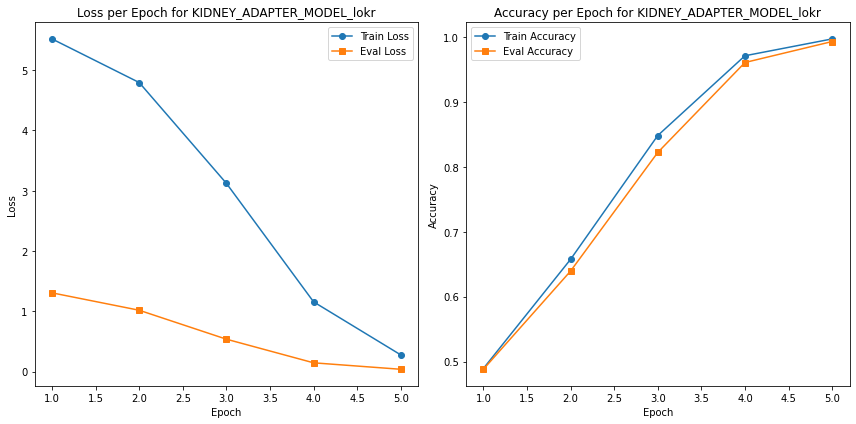

{'eval_loss': 0.03709942847490311, 'eval_accuracy': 0.9931972789115646, 'eval_f1': 0.9931969057962634, 'eval_precision': 0.9932083944688987, 'eval_recall': 0.9931972789115646, 'eval_runtime': 21.971, 'eval_samples_per_second': 53.525, 'eval_steps_per_second': 0.865, 'epoch': 4.918918918918919}


In [20]:
results = {}
for adapter_type in config_medX.keys():
    for lora_type in adapter_configs.keys():
        print(f"\nTraining {adapter_type} with {lora_type} type...")
        metrics = train_model_with_adapter(adapter_type, lora_type)
        results[f"{adapter_type}_{lora_type}"] = metrics

In [21]:
def display_results_as_table(results):
    '''Displays the evaluation metrics of multiple models in a neatly formatted table.'''
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = {
            "Adapter": adapter_type,
            "LoRA Type": lora_type,
            "Eval Loss": metrics.get("eval_loss", None),
            "Eval Accuracy": metrics.get("eval_accuracy", None),
            "Eval F1": metrics.get("eval_f1", None),
            "Eval Precision": metrics.get("eval_precision", None),
            "Eval Recall": metrics.get("eval_recall", None),
            "Epoch": metrics.get("epoch", None)
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["Adapter", "LoRA Type"])
    print("\n=== Comparison of All Adapter and LoRA Models ===")
    print(df.to_string(index=False))

display_results_as_table(results)


=== Comparison of All Adapter and LoRA Models ===
 Adapter                    LoRA Type  Eval Loss  Eval Accuracy  Eval F1  Eval Precision  Eval Recall    Epoch
   BRAIN  TUMOR_ADAPTER_MODEL_adalora   0.066013       0.979359 0.979277        0.979333     0.979359 5.000000
   BRAIN      TUMOR_ADAPTER_MODEL_ia3   0.087735       0.970107 0.969776        0.970740     0.970107 5.000000
   BRAIN     TUMOR_ADAPTER_MODEL_loha   0.068721       0.978648 0.978503        0.978818     0.978648 5.000000
   BRAIN     TUMOR_ADAPTER_MODEL_lokr   0.079973       0.972242 0.971963        0.972342     0.972242 5.000000
   BRAIN     TUMOR_ADAPTER_MODEL_lora   0.110818       0.965125 0.964919        0.965777     0.965125 5.000000
DIABETIC        ADAPTER_MODEL_adalora   0.526640       0.797000 0.795752        0.798885     0.797000 4.960000
DIABETIC            ADAPTER_MODEL_ia3   0.566268       0.779500 0.779568        0.779911     0.779500 4.960000
DIABETIC           ADAPTER_MODEL_loha   0.485602       0.8190

From the above results, it is evident that the **Brain Tumor adapter** achieves its best performance with the **ADALoRA type**, achieving an accuracy of **97.93%**, supported by the highest F1 score and lowest evaluation loss. This establishes ADALoRA as the most effective choice for Brain Tumor datasets. 

For the **Diabetic adapter** shows more lower performance, with accuracy ranging between **77% to 81%** across all LoRA types. The highest accuracy of **81.90%** was observed with the **LoHA adapter**, but the results indicate potential for improvement by applying feature-enhancing filters to better highlight diabetic-specific features.

For the **Kidney adapter**, the **LoRA adapter** is performing better but could have been overfit too among other types of lora. But upon performing inferences with new smaples, we observed its predictions are quite accurate.

In the case of the **Retina adapter**, the best performance is observed with the **LoHA type**, achieving an accuracy of **93.82%**, performing as good as Adalora and LoRA types.

Finally, for the **Skin Cancer adapter**, the performance is limited to the **85% to 90% range**, with the best accuracy of **90.25%** achieved by the LoHA adapter. However this could be due to several classes having some similaritites in skin diseases.

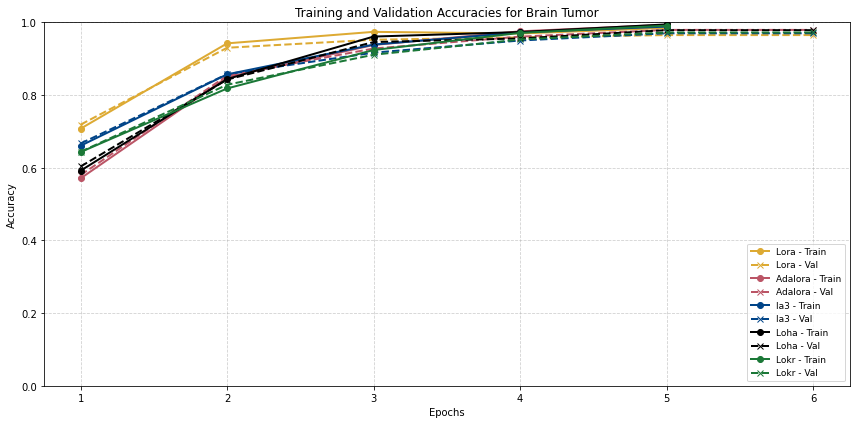

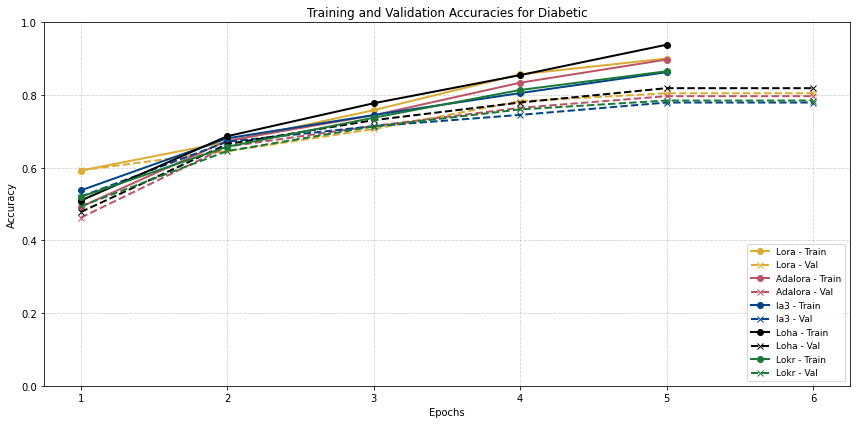

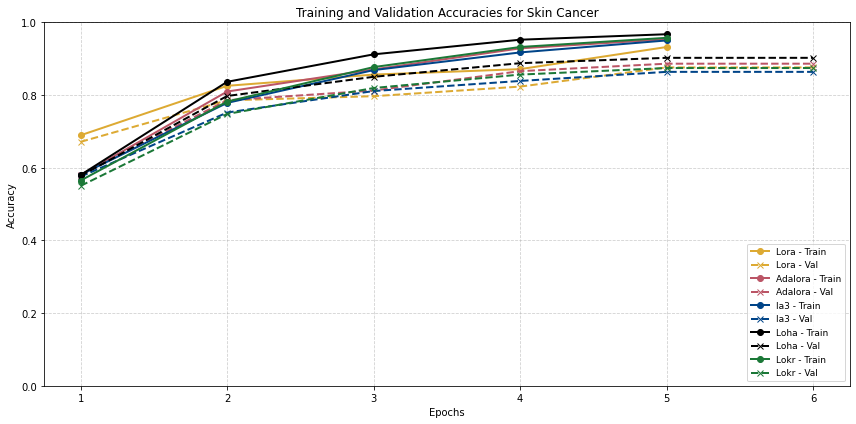

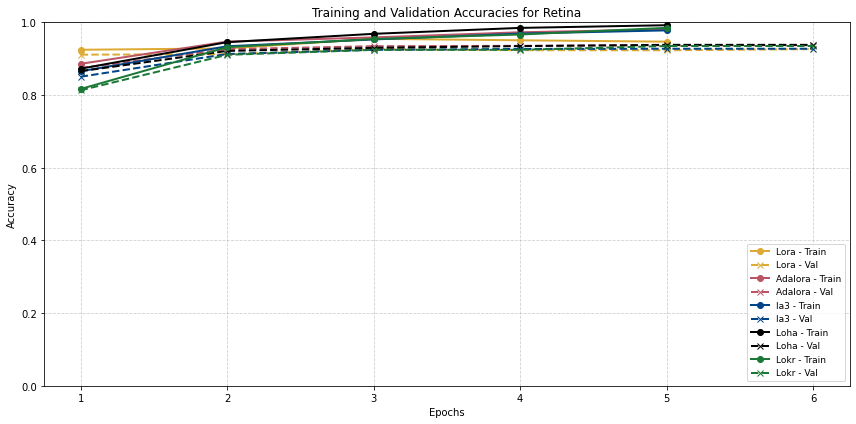

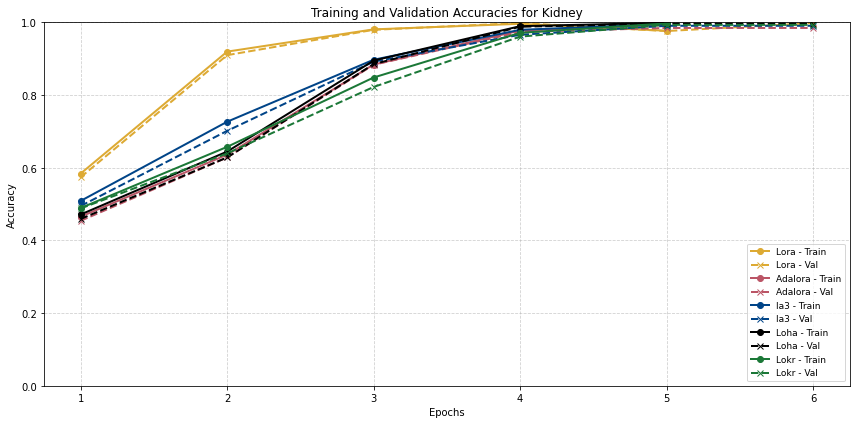

In [22]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837', '#117733', '#88CCEE']
def plot_accuracies_per_epoch(metrics_storage):
    '''Plots training and validation accuracies per epoch for each adapter and LoRA configuration.'''
    max_epochs = max(
        max(len(metrics.get('train_accuracy', [])), len(metrics.get('eval_accuracy', [])))
        for lora_metrics in metrics_storage.values() for metrics in lora_metrics.values()
    )
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (lora_type, metrics) in enumerate(lora_metrics.items()):
            train_accuracies = metrics.get('train_accuracy', [])
            val_accuracies = metrics.get('eval_accuracy', [])
            train_accuracies = np.array(train_accuracies + [np.nan] * (max_epochs - len(train_accuracies)))
            val_accuracies = np.array(val_accuracies + [np.nan] * (max_epochs - len(val_accuracies)))
            epochs = np.arange(1, max_epochs + 1)
            ax.plot(epochs, train_accuracies, marker='o', linestyle='-', 
                    label=f'{lora_type.capitalize()} - Train', 
                    color=colors[i % len(colors)], linewidth=2)
            ax.plot(epochs, val_accuracies, marker='x', linestyle='--', 
                    label=f'{lora_type.capitalize()} - Val', 
                    color=colors[i % len(colors)], linewidth=2)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)
        ax.set_title(f'Training and Validation Accuracies for {adapter_name.replace("_ADAPTER_MODEL", "").replace("_", " ").title()}')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
plot_accuracies_per_epoch(metrics_storage)

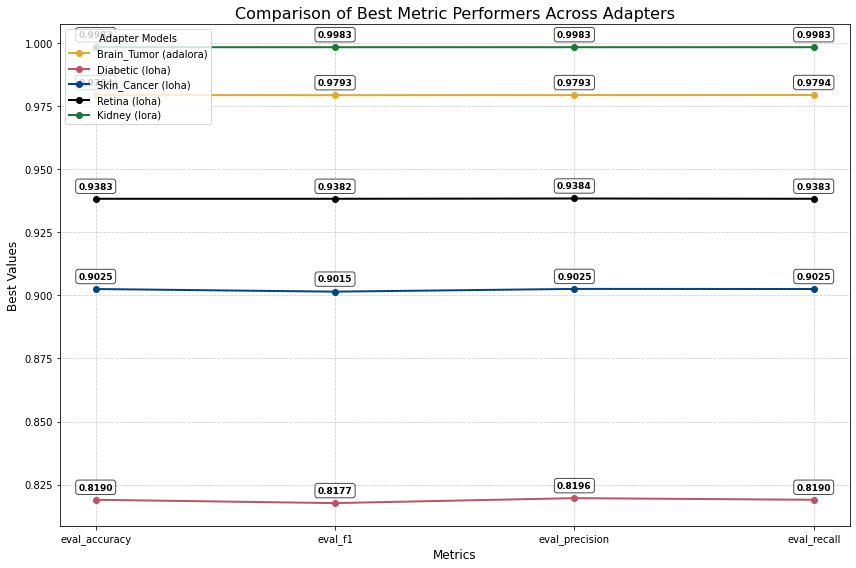

In [ ]:
def get_best_metrics(metrics_storage, metric_labels):
    '''
    Identifies the best-performing LoRA configuration for each adapter model based on the highest value
    of the first metric in metric_labels (e.g., "eval_accuracy"). It then records the best values of all 
    specified metrics for that chosen LoRA configuration.
    '''
    best_metrics = {}
    for adapter_name, lora_metrics in metrics_storage.items():
        best_metrics[adapter_name] = {"lora_type": None, "metrics": {}}
        best_value = -np.inf
        best_lora_type = None
        for lora_type, metrics in lora_metrics.items():
            metric_values = metrics.get(metric_labels[0].lower(), [])
            if metric_values:
                max_value = max(metric_values)
                if max_value > best_value:
                    best_value = max_value
                    best_lora_type = lora_type
        best_metrics[adapter_name]["lora_type"] = best_lora_type
        for metric in metric_labels:
            metric_values = lora_metrics[best_lora_type].get(metric.lower(), [])
            best_metrics[adapter_name]["metrics"][metric] = max(metric_values) if metric_values else None
    return best_metrics


def plot_comparison_of_best_performers(best_metrics, metric_labels):
    '''
    Plots a comparison chart of the best values of multiple metrics for each adapter’s best-performing LoRA configuration.
    Each adapter is represented by a line connecting the metric values, with annotations for the actual numeric values.
    '''
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837']
    for i, (adapter_name, data) in enumerate(best_metrics.items()):
        lora_type = data["lora_type"]
        values = [data["metrics"][metric] for metric in metric_labels]
        ax.plot(
            metric_labels, values, marker='o',
            label=f"{adapter_name.replace('_ADAPTER_MODEL', '').title()} ({lora_type})",
            linewidth=2, color=colors[i % len(colors)]  
        )
        for idx, (x, y) in enumerate(zip(metric_labels, values)):
            if y is not None:
                ax.annotate(
                    f"{y:.4f}",
                    xy=(x, y),
                    xytext=(0, 10),  
                    textcoords='offset points',  
                    fontsize=9, fontweight='bold', ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
                )

    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Best Values', fontsize=12)
    ax.set_title('Comparison of Best Metric Performers Across Adapters', fontsize=16)
    ax.legend(title='Adapter Models', loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    
metric_labels = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
best_metrics = get_best_metrics(metrics_storage, metric_labels)
plot_comparison_of_best_performers(best_metrics, metric_labels)


**We applied Filters for Diabetic, Kidney and Skin Cancer dataset to improve the performances for Diabetic Retinopathy classification, reduce overfitting in kideny models and better classify 9 different skin cancers.**